# Life-Cycle Model

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def u(c,gamma):
    util = -np.inf*np.ones(np.ma.size(c,0))
    if gamma==1.0:
        util[c>0] = np.log(c[c>0])
    else :
        util[c>0] = c[c>0]**(1.0-gamma)/(1.0-gamma)
    return util

## Define parameters


In [3]:
gamma = 0.75
delta = 0.98
R = 1.0/delta
T = 75
ret = 40
base = 30e3
g = 0.01
rep = 0.5
income = [base*np.exp(g*t) for t in range(T)]
for t in range(T):
    if (t>=ret):
        income[t] = income[ret-1]*rep
w0 = 50e3
age = [t for t in range(T)]

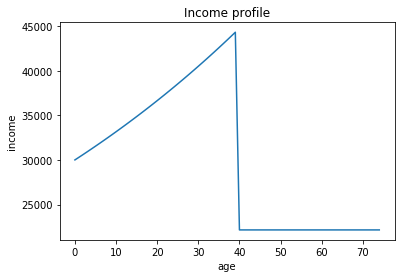

In [4]:
plt.figure()
plt.plot(age,income)
plt.xlabel('age')
plt.ylabel('income')
plt.title('Income profile')
plt.show()

## Set up space for solution

### Grid for wealth

In [5]:
nw = 500
wmin = 0.0
wmax = 2e6
gw = np.linspace(wmin,wmax,nw)

In [6]:
gw

array([      0.        ,    4008.01603206,    8016.03206413,
         12024.04809619,   16032.06412826,   20040.08016032,
         24048.09619238,   28056.11222445,   32064.12825651,
         36072.14428858,   40080.16032064,   44088.17635271,
         48096.19238477,   52104.20841683,   56112.2244489 ,
         60120.24048096,   64128.25651303,   68136.27254509,
         72144.28857715,   76152.30460922,   80160.32064128,
         84168.33667335,   88176.35270541,   92184.36873747,
         96192.38476954,  100200.4008016 ,  104208.41683367,
        108216.43286573,  112224.4488978 ,  116232.46492986,
        120240.48096192,  124248.49699399,  128256.51302605,
        132264.52905812,  136272.54509018,  140280.56112224,
        144288.57715431,  148296.59318637,  152304.60921844,
        156312.6252505 ,  160320.64128257,  164328.65731463,
        168336.67334669,  172344.68937876,  176352.70541082,
        180360.72144289,  184368.73747495,  188376.75350701,
        192384.76953908,

### Value and consumption

In [37]:
V = np.zeros((nw,T))
copt = np.zeros((nw,T))

### Final year

In [38]:
copt[:,T-1] = gw + income[T-1]
V[:,T-1] = u(copt[:,T-1],gamma)

### Other Years

In [39]:
for t in reversed(range(T-1)):
    cash = gw + income[t]
    for i in range(nw):
        cons = cash[i] - gw/R
        now = u(cons,gamma) 
        vprime = now + delta*V[:,t+1]
        j = np.argmax(vprime)
        V[i,t] = vprime[j]
        copt[i,t] = cons[j]                


### Plot decision rules

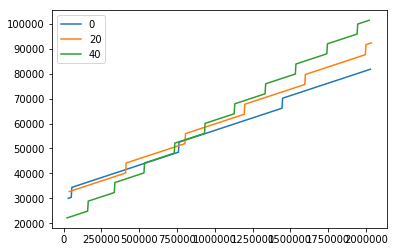

In [40]:
yrs = [0,20,40]
plt.figure()
for yr in yrs:
    plt.plot(gw+income[yr],copt[:,yr],label=str(yr))
plt.legend()
plt.show()

### Simulating

In [41]:
from scipy.interpolate import interp1d
w0 = 0.0
wealth = np.zeros(T)
cons = np.zeros(T)
wealth[0] = w0
for t in range(T):
    c = interp1d(gw,copt[:,t])
    cons[t] = c(wealth[t])
    if t<T-1:
        wealth[t+1] = R*(wealth[t] + income[t] - cons[t])
    

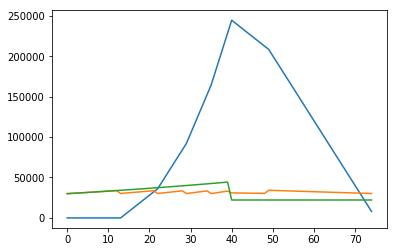

In [42]:
plt.figure()
plt.plot(age,wealth,label='wealth')
plt.plot(age,cons,label='consumption')
plt.plot(age,income,label='income')

# Infinite Horizon

## Solution

In [43]:
V = np.zeros(nw)
Vprime = np.zeros(nw)
copt = np.zeros(nw)
cprime = np.zeros(nw)
y = np.mean(income)
iter = 0
criterion = 10.0
while criterion>1e-8:
    cash = gw + y
    for i in range(nw):
        cons = cash[i] - gw/R
        now = u(cons,gamma)         
        vp = now + delta*V
        j = np.argmax(vp)
        Vprime[i] = vp[j]
        cprime[i] = cons[j] 
    criterion = np.max(np.abs(cprime-copt))
    V[:] = Vprime[:]
    copt[:] = cprime[:]
    iter +=1    

In [44]:
iter

152

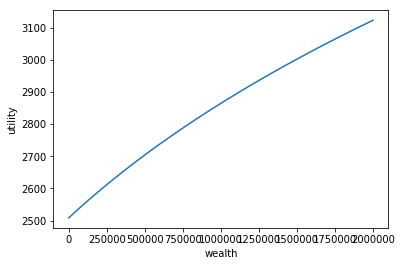

In [45]:
plt.figure()
plt.plot(gw,V)
plt.xlabel('wealth')
plt.ylabel('utility')
plt.show()

## Add an income shock (Optional)

In [46]:
nshock = 5
shock = np.linspace(0.5,2.0,nshock)
pshock = np.zeros((nshock,nshock))
for i in range(nshock):
    pshock[i,i] = 0.97
    for j in range(nshock):
        if j!=i:
            pshock[i,j] = (1.0-pshock[i,i])/(nshock-1.0)
print(pshock)
print(shock)

[[0.97   0.0075 0.0075 0.0075 0.0075]
 [0.0075 0.97   0.0075 0.0075 0.0075]
 [0.0075 0.0075 0.97   0.0075 0.0075]
 [0.0075 0.0075 0.0075 0.97   0.0075]
 [0.0075 0.0075 0.0075 0.0075 0.97  ]]
[0.5   0.875 1.25  1.625 2.   ]


In [47]:
V = np.zeros((nw,nshock))
Vprime = np.zeros((nw,nshock))
copt = np.zeros((nw,nshock))
cprime = np.zeros((nw,nshock))
y = np.mean(income)
iter = 0
criterion = 10.0
while criterion>1e-8:
    for e in range(nshock):
        cash = gw + y*shock[e]
        for i in range(nw):
            cons = cash[i] - gw/R
            now = u(cons,gamma)
            ev = np.zeros(nw)
            for ee in range(nshock):
                    ev += pshock[e,ee]*V[:,ee]
            vp = now + delta*ev
            j = np.argmax(vp)
            Vprime[i,e] = vp[j]
            cprime[i,e] = cons[j] 
    criterion = np.max(np.abs(cprime-copt))
    V[:,:] = Vprime[:,:]
    copt[:,:] = cprime[:,:]
    iter +=1  

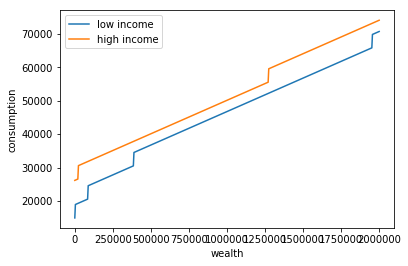

In [48]:
plt.figure()
plt.plot(gw,copt[:,0],label='low income')
plt.plot(gw,copt[:,1],label='high income')
plt.xlabel('wealth')
plt.ylabel('consumption')
plt.legend()
plt.show()

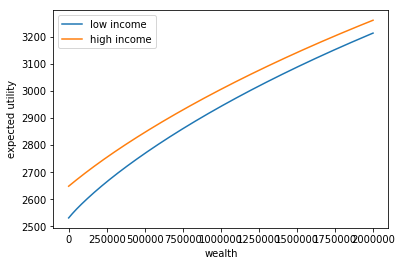

In [49]:
plt.figure()
plt.plot(gw,V[:,0],label='low income')
plt.plot(gw,V[:,1],label='high income')
plt.xlabel('wealth')
plt.ylabel('expected utility')
plt.legend()
plt.show()

### Stationary Distribution

In [50]:
wsim = []
nsim = 10000
c = []
for e in range(nshock):
    c.append(interp1d(gw,copt[:,e]))
w = 0.0
sim = 0
esim = 0
for s in range(nsim):
        wp = R*(w + y*shock[int(esim)] - c[int(esim)](w))
        if wp<0.0:
            wp = 0.0
        esim = np.random.choice(nshock, 1, p=pshock[int(esim),:])
        wsim.append(wp)
        w = wp

Text(0,0.5,'frequency')

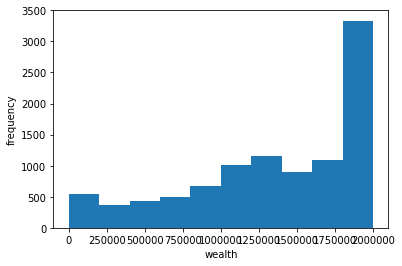

In [51]:
plt.figure()
plt.hist(wsim)
plt.xlabel('wealth')
plt.ylabel('frequency')